<a id='main'></a>

### Data & Folders
[Data & Folders](#data_folders)

### Scenarios covered
[List of scenarios](#scenes)

### Functions
[functions](#functions)

### Plots:
[plots](#plots)

In [1]:
import csv
import os
os.chdir('../') # important if this notebook is not in main but in notebooks folder

import gerda.utilities.VPM_plotting as vpm_plot
import gerda.utilities.parallel_utilities as plt_para
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

from gerda.core.virusPropagationModel import *
from gerda.utilities.VPM_plotting_parallel import *
from functools import partial

%matplotlib inline

defaultCmap = cm.get_cmap('Set2')
red_pur_Cmap = cm.get_cmap('PuRd')
reds_Cmap = cm.get_cmap('Reds')


#confi_z_dict = { 99 : 2.576, 
#                 98 : 2.326,
#                 95 : 1.96,
#                 90 : 1.645,}
#ci = z*sigma/sqrt(n)

<a id='data_folders'></a>
### Data &  Folders 
[back to top](#main)

In [2]:
server_data_folder_str = '/media/hexe/grossePlatte/job/coronaModel/simulation_results/'
## local folder synchronized with basar/corona_simulations_save/simulation_results_20201028
scenarios_list = os.listdir(server_data_folder_str)
scenarios_list.sort()

output_folder = '/media/hexe/grossePlatte/job/coronaModel/simulation_plots/'

print(len(scenarios_list))
scenarios_list

74


['additional_locations',
 'base_scenario',
 'base_scenario_inf_0.15',
 'close_all_336',
 'close_public_home_office_scan_0.2_0.9',
 'close_public_inf_0.15',
 'disobedience_scan_0.00_0.45',
 'fixed_base_scenario',
 'fixed_recover_age_scan_0.1_0.9',
 'fixed_recover_age_scan_0.1_0.9_inf_0.15',
 'fixed_recover_age_scan_part_imnty_0.1_sus_0.1_0.9',
 'fixed_recover_age_scan_part_imnty_inf_0.1_0.9',
 'fixed_recover_age_scan_part_imnty_sus_0.1_0.9',
 'fixed_recover_ageinteractions_scan_0.1_0.9',
 'fixed_recover_from_world_scan_0.1_0.9',
 'fixed_recover_households_scan_0.1_0.9',
 'fixed_recover_interactions_scan_0.1_0.9',
 'fixed_recover_interactions_scan_0.1_0.9_inf_0.15',
 'fixed_recover_interactions_scan_part_imnty_0.1_sus_0.1_0.9',
 'fixed_recover_overrepresentation_scan_0.1_0.9',
 'fixed_recover_random_scan_0.1_0.9',
 'fixed_recover_random_scan_0.1_0.9_inf_0.15',
 'fixed_timecourses_for_network',
 'incidence_scan_LockDownLight',
 'incidence_scan_LockDownLight_2',
 'incidence_scan_control',


<a id='scenes'></a>
### List of Scenarios covered by the notebook 
[back to top](#main)

In [3]:
## adapt scenarios list to contain only scaned scenarios from after fixing
scans_per_scene_dict = {}
#scenarios_list = [x for x in scenarios_list if 'scan' in x]
for scene in scenarios_list:
    working_dir = server_data_folder_str + scene + '/'
    scans_list = os.listdir(working_dir)
    scans_list = [x for x in scans_list if '.pptx' not in x and 'plots' not in x]
    scans_per_scene_dict[scene] = scans_list

scenarios_list = [x for x in scenarios_list if len(scans_per_scene_dict[x]) > 1 and 'fixed' in x]

print(len(scenarios_list))
scenarios_list

14


['fixed_recover_age_scan_0.1_0.9',
 'fixed_recover_age_scan_0.1_0.9_inf_0.15',
 'fixed_recover_age_scan_part_imnty_0.1_sus_0.1_0.9',
 'fixed_recover_age_scan_part_imnty_inf_0.1_0.9',
 'fixed_recover_age_scan_part_imnty_sus_0.1_0.9',
 'fixed_recover_ageinteractions_scan_0.1_0.9',
 'fixed_recover_from_world_scan_0.1_0.9',
 'fixed_recover_households_scan_0.1_0.9',
 'fixed_recover_interactions_scan_0.1_0.9',
 'fixed_recover_interactions_scan_0.1_0.9_inf_0.15',
 'fixed_recover_interactions_scan_part_imnty_0.1_sus_0.1_0.9',
 'fixed_recover_overrepresentation_scan_0.1_0.9',
 'fixed_recover_random_scan_0.1_0.9',
 'fixed_recover_random_scan_0.1_0.9_inf_0.15']

<a id='functions'></a>
### Functions 
[back to top](#main)

In [4]:
def get_df_stat(folder_scenario,server_data_folder, stat='I'):
    assert stat in ['I','D','R','S'], stat+" not in ['I','D','R','S']"
    try:
        df_stat = pd.read_csv(server_data_folder + folder_scenario +
                         '/'+folder_scenario+'_'+stat+'.csv')
    except:
        try:
            df_stat = pd.read_csv(server_data_folder + folder_scenario +
                             '/IAR_1_0_99_'+folder_scenario[:-10]+'_'+stat+'.csv')
        except:
            print("can't read ", server_data_folder + folder_scenario +
                  '/'+folder_scenario+'_'+stat+'.csv')
    return(df_stat.drop('time', axis=1))

In [5]:
def assign_subplot_grid(scan_length):
    if scan_length > 1 and scan_length <= 3:
        x = scan_length
        y = 1
    elif scan_length <= 8 or scan_length == 10:
        x = int((scan_length+1)/2)
        y = 2
    elif scan_length == 9 or scan_length == 11 or scan_length == 14:
        x = int((scan_length+1)/3)
        y = 3
    elif scan_length == 21:
        x = 7
        y = 3
    else:
        print("problem: number of subplots exceeds figure definitions: " + str(scan_length))
        
    return(x,y)

In [6]:

def plot_statii_for_scan(server_data_folder, scenario, scans_list, x=5, y=2, prefix=3, suffix=10,\
                         statii=['I', 'D', 'R', 'D'], scan_order=[]):
    ## define basic figure properties
    scale_factor = 12/x
    data_folder = server_data_folder + scenario + '/'
    fig, axes = plt.subplots(y, x, figsize=(12,y*scale_factor), sharey=True, sharex=True)
    ax_series = axes.flatten()
    
    ## change subfolder (and thus subplot) order according to a given order list (containing unique
    ## substrings of subfolders)
    if len(scan_order) > 0:
        tmp_list = []
        for scan in scan_order:
            for folder in scans_list:
                if scan in folder:
                    tmp_list.append(folder) 
        scans_list = tmp_list.copy()
    
    ## create subplot for each subfolder
    for k,s in enumerate(scans_list):
        ax_series[k].set_ylim(0.1, 9000)
        plot_stat_para(ax_series[k], s, data_folder, statii=statii, log=True, prefix = prefix, suffix = suffix)
        ## account for diverse naming conventions of simulation result files
        if 'IF03' in s:
            inf = 'IF03_'
        elif 'IF015' in s:
            inf = 'IF015'
        try:
            title = s.split('_ri')[0].split(inf)[1].split('_')[3]
            if title == 'rw':
                title = s.split('_ri')[0].split(inf)[1].split('_')[2]
        except:
            try:
                title = s.split('_ri')[0].split(inf)[1].split('_')[2]
            except:
                title = s.split('_ri')[0].split(inf)[1].split('_')[1]
        while title[-1] == '0':
            title = title[0:-1]
        if title[-1] == '.':
            title = title[0:-1]
        ax_series[k].set_title(title)
    plt.tight_layout()
    
    return(ax_series, fig)

<a id='plots'></a>
# Plots (after fixing)
[back to top](#main)

Scan Themes:

[recover by age](#recAge)

[recover from world](#recWorld)

[recover by household](#recHouse)

[recover based on overrepresentation](#recOverrep)

[recover random](#recRand)

<a id='recAge'></a>
### recover by age

[back to plot overview](#plots)

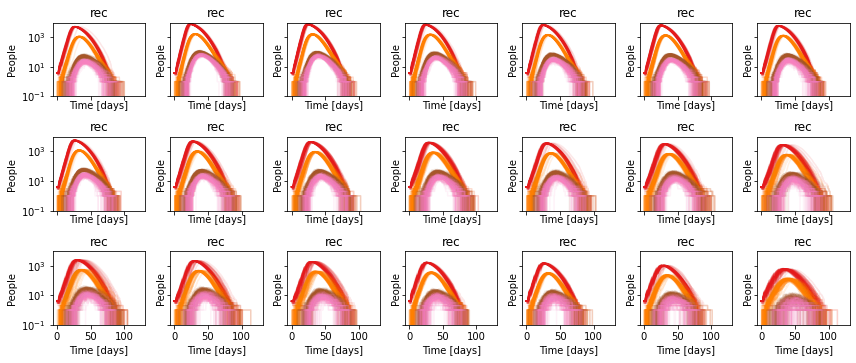

In [8]:
scan = 'fixed_recover_age_scan_0.1_0.9'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

output_folder = data_folder + "/plots/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig1 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, statii=states_list)
fig1.savefig(output_folder + "/fixed_recover_age_scan_0.1_0.9_flags.png")

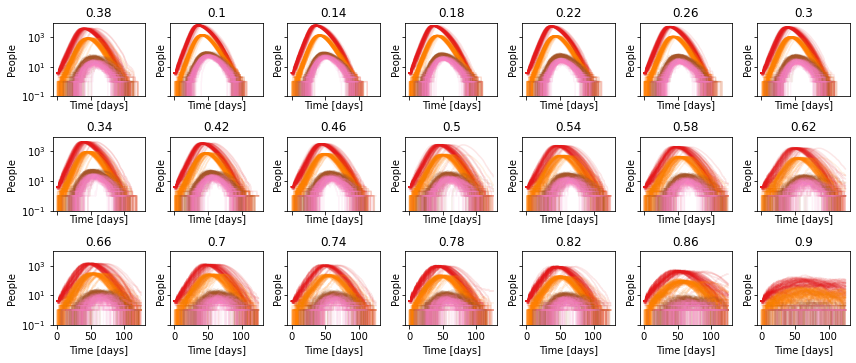

In [9]:
scan = 'fixed_recover_age_scan_0.1_0.9_inf_0.15'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

output_folder = data_folder + "/plots/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, figB = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, statii=states_list)
figB.savefig(output_folder + "/fixed_recover_age_scan_0.1_0.9_inf_0.15_flags.png")

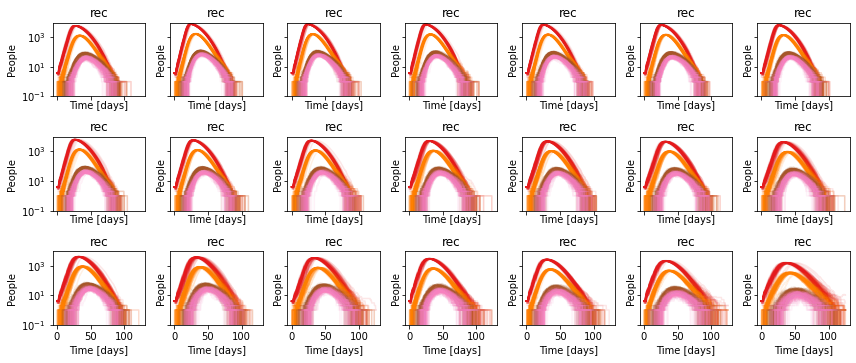

In [10]:
scan = 'fixed_recover_age_scan_part_imnty_0.1_sus_0.1_0.9'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

output_folder = data_folder + "/plots/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, figC = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, statii=states_list)
figC.savefig(output_folder + "/fixed_recover_age_scan_part_imnty_0.1_sus_0.1_0.9_flags.png")

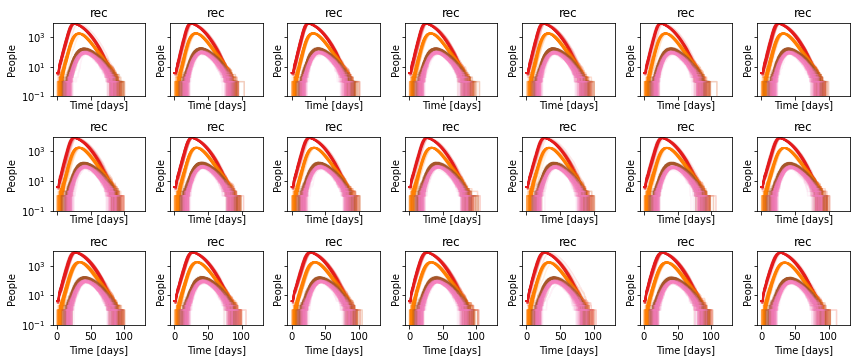

In [11]:
scan = 'fixed_recover_age_scan_part_imnty_inf_0.1_0.9'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

output_folder = data_folder + "/plots/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, figD = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, statii=states_list)
figD.savefig(output_folder + "/fixed_recover_age_scan_part_imnty_inf_0.1_0.9_flags.png")

In [ ]:
scan = 'fixed_recover_age_scan_part_imnty_sus_0.1_0.9'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

output_folder = data_folder + "/plots/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, figE = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, statii=states_list)
figE.savefig(output_folder + "/fixed_recover_age_scan_part_imnty_sus_0.1_0.9_flags.png")

<a id='recWorld'></a>
### recover from world

[back to plot overview](#plots)

In [ ]:
scan = 'fixed_recover_age_scan_part_imnty_sus_0.1_0.9'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

output_folder = data_folder + "/plots/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, figF = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, statii=states_list)
figF.savefig(output_folder + "/fixed_recover_age_scan_part_imnty_sus_0.1_0.9_flags.png")

<a id='plots_before'></a>
# Plots (before fixing)
[back to top](#main)

Scan Themes:

[disobedience scan](#disobey) 

[home office scan](#homeoffice) 

[incidence scans](#incidence) 

[infectivity scan](#infectivity) 

[lockdown scans](#lockstart) 

[product composition scan](#product) 

[recovery (vaccination) scans](#recover) 

[reopening scans](#reopen)

[interaction frequency scans](#if)

<a id='disobey'></a>
### disobedience scan

[back to plot overview](#plots)

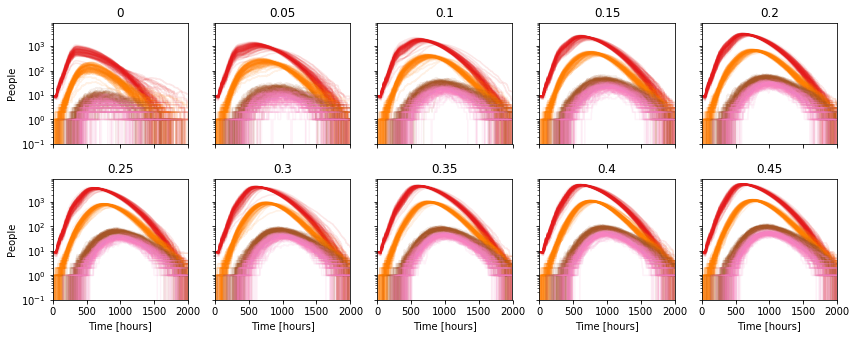

In [9]:
scan = 'disobedience_scan_0.00_0.45'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig1 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, statii=states_list)

fig1.savefig(output_folder + "/Disobedience_Fraction_Scan_0_0.45_flags.png")

<a id='homeoffice'></a>
### home office scan

[back to plot overview](#plots)

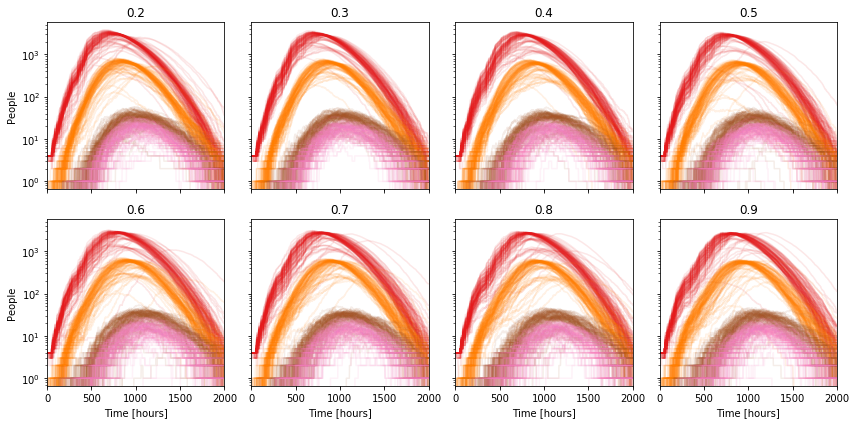

In [10]:
scan = 'close_public_home_office_scan_0.2_0.9'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig2 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, statii=states_list)
fig2.savefig(output_folder + "/ClosePublic_HomeOffice_Fraction_Scan_0.2_0.9_flags.png")

<a id='indectivity'></a>
### infectivity scan

[back to plot overview](#plots)

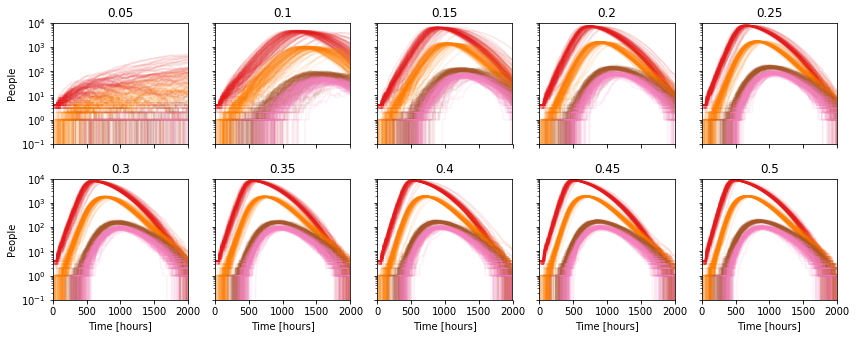

In [12]:
## infectivity_scan_0.025_0.500 should be deleted, contains crashed sims and is redundant w the below
scan = 'infectivity_scan_0.05_0.50'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig5 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, statii=states_list)
for axis in ax_series:
    axis.set_ylim(0.1, 10000)
fig5.savefig(output_folder + "/Infectivity_Scan_0.05_0.5_flags.png")

<a id='lockstart'></a>
### lockdown scans

[back to plot overview](#plots)

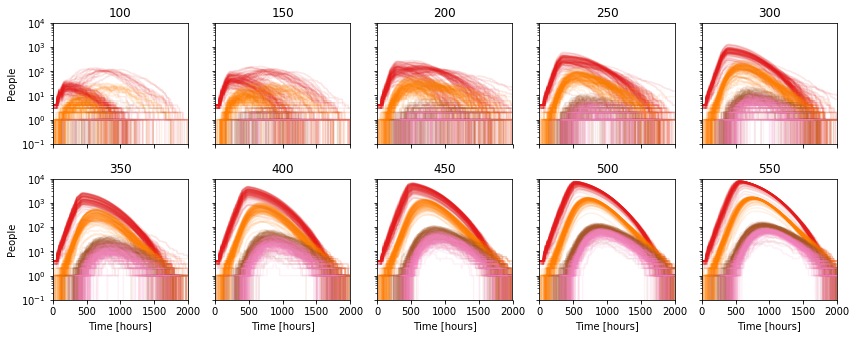

In [16]:
scan = 'lockdown_start_scan_100_550'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig6 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,\
                                       statii = states_list)
for axis in ax_series:
    axis.set_ylim(0.1, 10000)
fig6.savefig(output_folder + "/Lockdown_Start_Scan_100_550_flags.png")

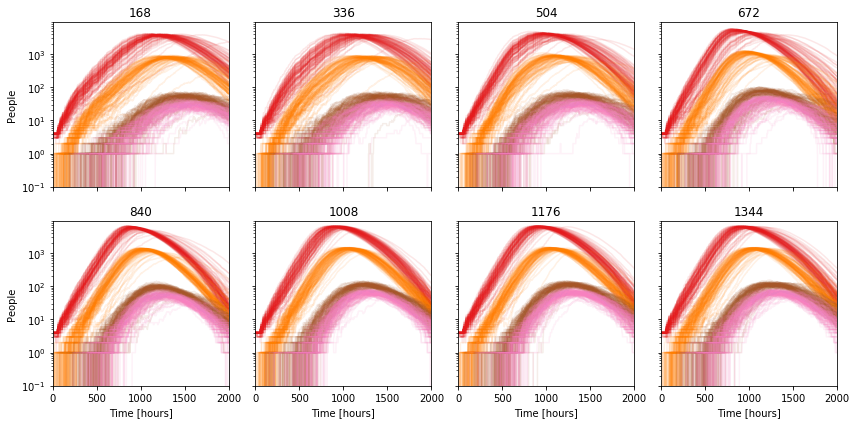

In [14]:
scan = 'close_public_inf_0.15'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
subplot_order_list = ['_168.000', '_336.000', '_504.000', '_672.000', '_840.000', '_1008.000', \
                      '_1176.000', '_1344.000']
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, figx1 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10, \
                                       scan_order = subplot_order_list, statii = states_list)
figx1.savefig(output_folder + "/close_public_start_times_scan_flags.png")

<a id='product'></a>
### product composition scans

[back to plot overview](#plots)

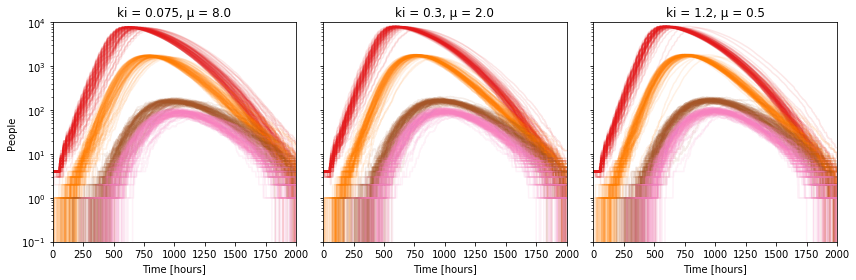

In [28]:
scan = 'product_0.6_scan_inf_0.075_1.200'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig7 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,\
                                      statii = states_list)
for k,s in enumerate(subfolder_list):
    ki = float(s.split('_ri')[0].split('IF03_')[1].split('_')[3])
    mu = 0.6 / ki
    ax_series[k].set_title('ki = ' + str(ki) + ', µ = ' + str(mu))#.set_text('ki = ' + str(ax_series[k].title[2]))
    ax_series[k].set_ylim(0.1, 10000)
fig7.savefig(output_folder + "/Product_0.6_Scan_inf_0.075_1.2_flags.png")

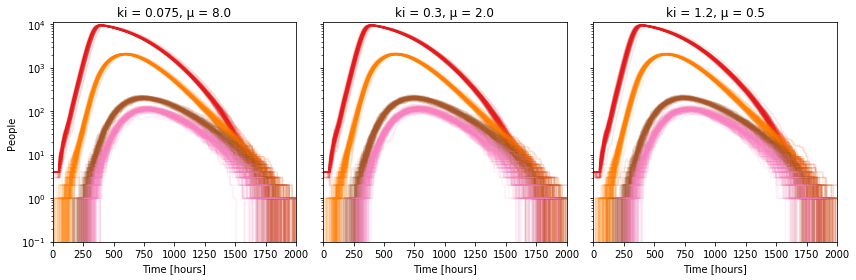

In [30]:
scan = 'mix_product_0.6'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, figx2 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,\
                                       statii = states_list)
for k,s in enumerate(subfolder_list):
    ki = float(s.split('_ri')[0].split('IF03_')[1].split('_')[3])
    mu = 0.6 / ki
    ax_series[k].set_title('ki = ' + str(ki) + ', µ = ' + str(mu))
    ax_series[k].set_ylim(0.1, 11000)
figx2.savefig(output_folder + "/Product_0.6_Scan_Mixing_Location_flags.png")

<a id='recover'></a>
### recovery (vaccionation) scans

[back to plot overview](#plots)

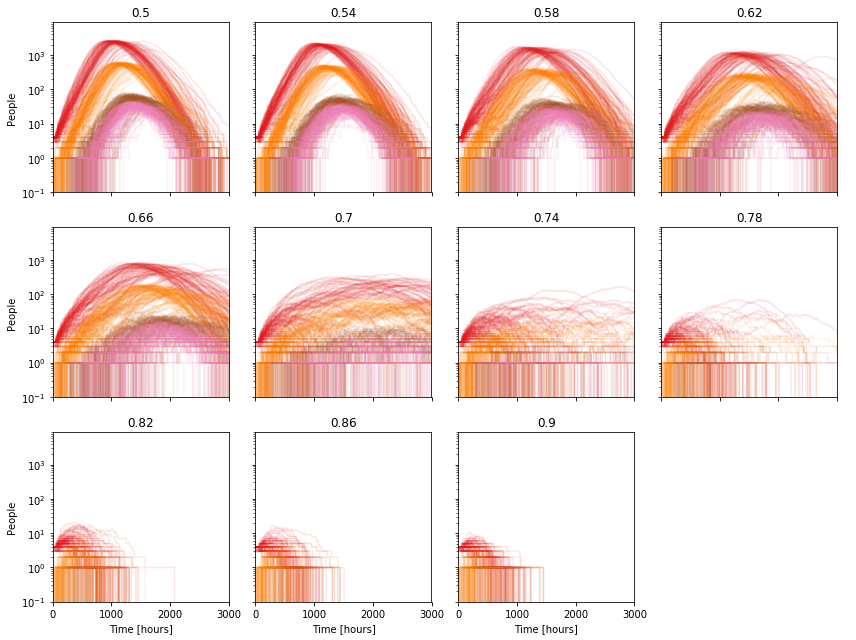

In [9]:
scan = 'recover_from_world_scan_0.5_0.9'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig8 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,\
                                      statii=states_list)
ax_series[-1].axis('off')
fig8.savefig(output_folder + "/Recovery_Fraction_Scan_0.5_0.9_flags.png")

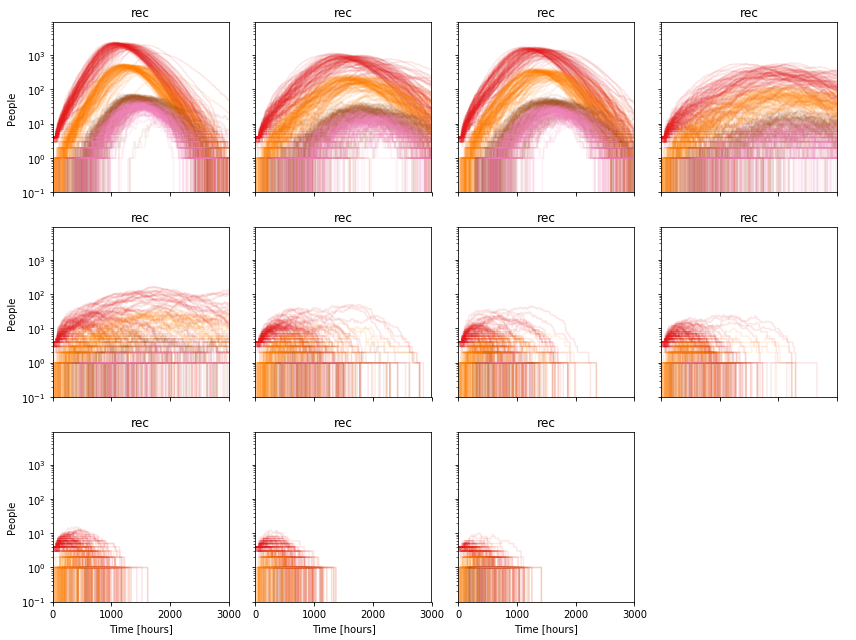

In [18]:
scan = 'recover_interaction_scan_0.5_0.9'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig9 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,\
                                      statii=states_list)
ax_series[-1].axis('off')
fig9.savefig(output_folder + "/Recover_Interaction_Scan_0.5_0.9_flags.png")

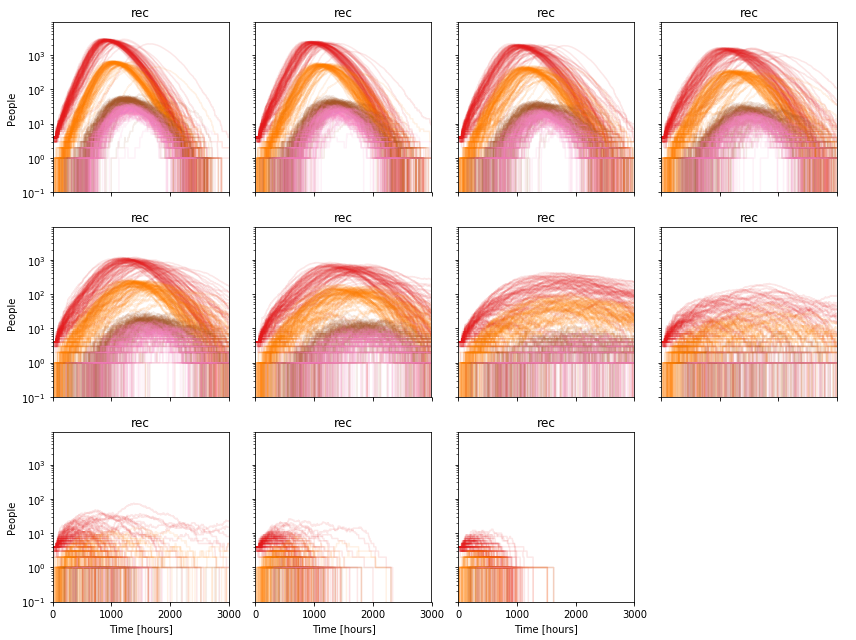

In [23]:
scan = 'recover_random_scan_0.5_0.9'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig9 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,\
                                      statii=states_list)
ax_series[-1].axis('off')
fig9.savefig(output_folder + "/Recover_Random_Scan_0.5_0.9_flags.png")

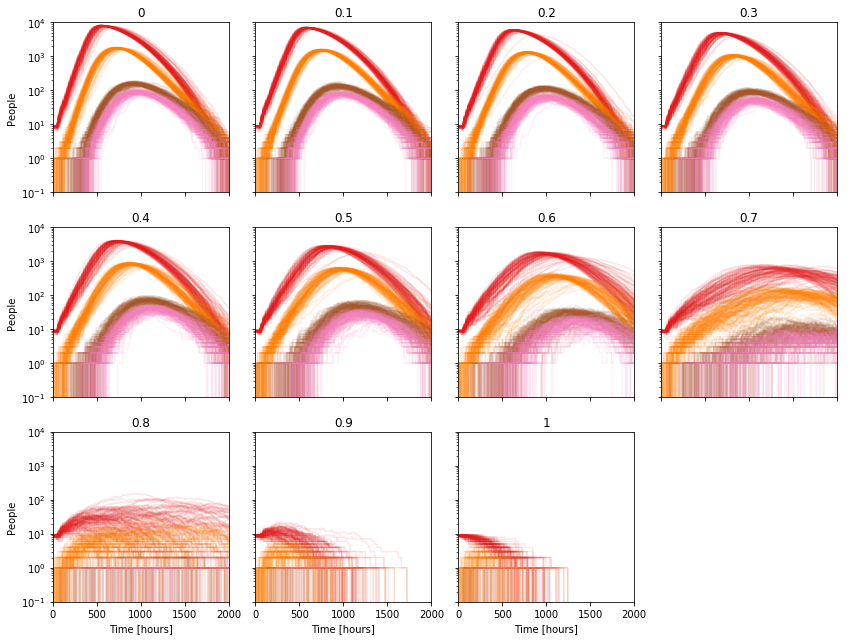

In [31]:
scan = 'recover_random_scan_0_1'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig10 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,\
                                      statii=states_list)
for axes in ax_series:
    axes.set_ylim(0.1, 10000)
ax_series[-1].axis('off')
fig10.savefig(output_folder + "/Recover_Random_Scan_0_1_flags.png")

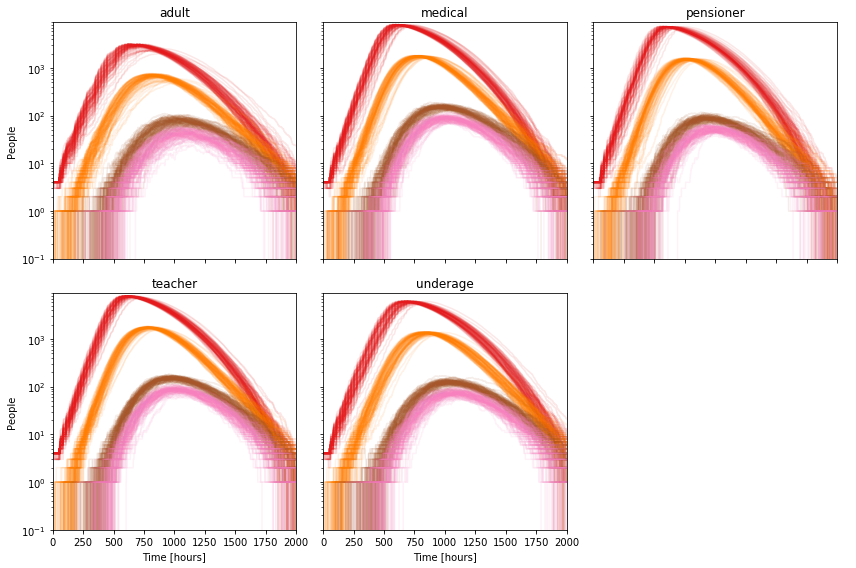

In [32]:
scan = 'recover_schedule_type'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, figA = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,\
                                      statii=states_list)
for n, axis in enumerate(ax_series):
    if n <= 4:
        title = subfolder_list[n].split('_', 6)[4]
        axis.set_title(title)
ax_series[-1].axis('off')
figA.savefig(output_folder + '/Recover_Schedule_Type_Scan_flags.png')

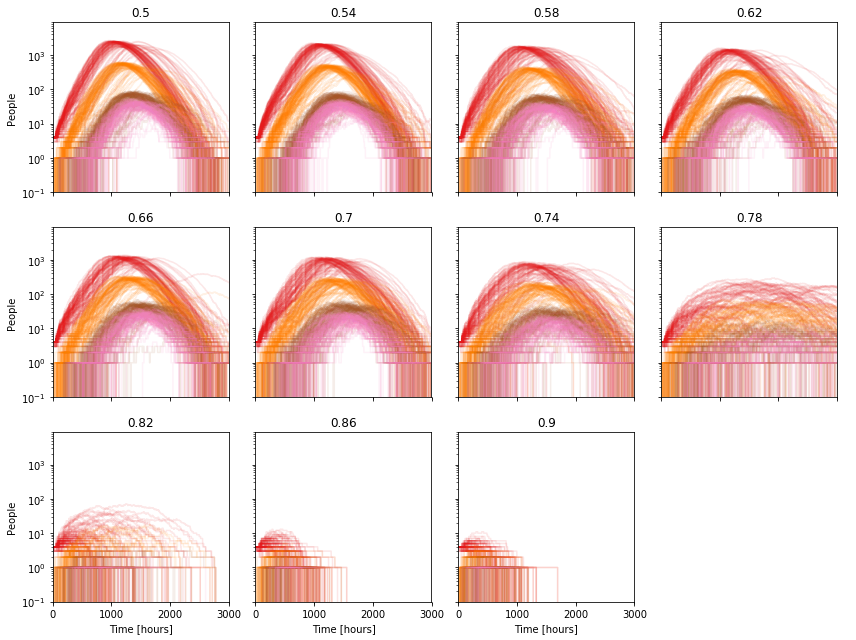

In [33]:
scan = 'recover_ordered1_0.5_0.9'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, figx3 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,\
                                       statii=states_list)
ax_series[-1].axis('off')
figx3.savefig(output_folder + '/Recover_Ordered1_Scan_flags.png')

<a id='reopen'></a>
### reopening scans

[back to plot overview](#plots)

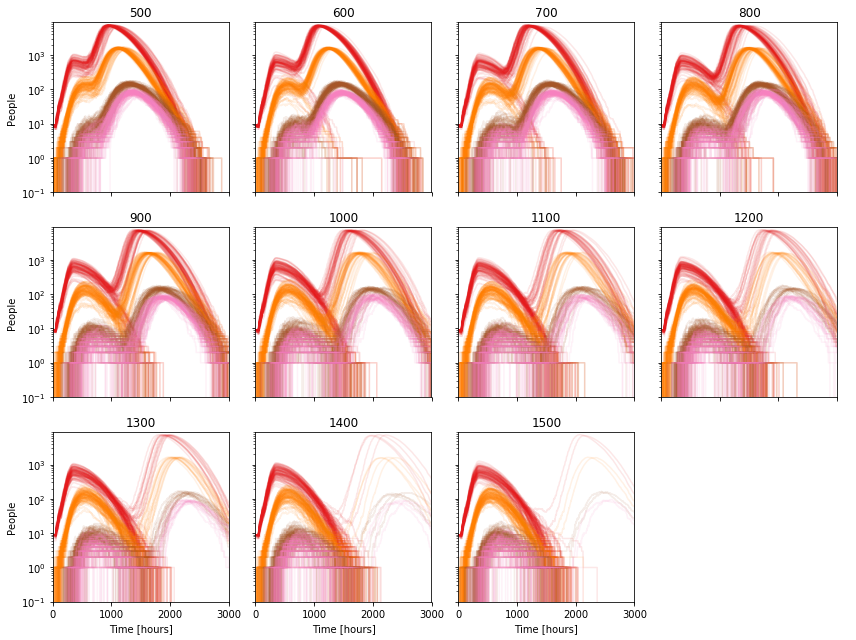

In [34]:
scan = 'reopen_all_scan_500_1500'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']
subplot_order_list = ['_500.000', '_600.000', '_700.000', '_800.000', '_900.000', '_1000.000', \
                      '_1100.000', '_1200.000', '_1300.000', '_1400.000', '_1500.000']


scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig11 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,\
                                        scan_order=subplot_order_list, statii=states_list)
ax_series[-1].axis('off')
fig11.savefig(output_folder + "/Reopen_All_Scan_500_1500_flags.png")

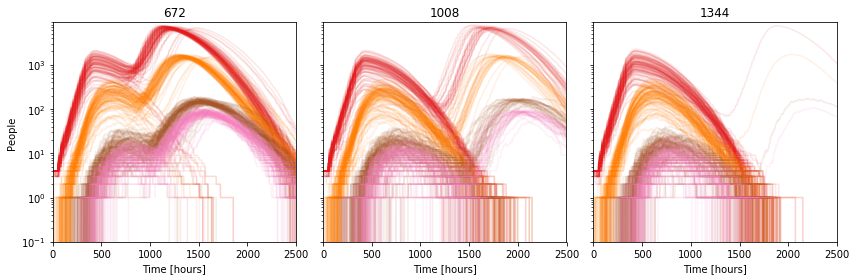

In [35]:
scan = 'reopen_all_scan_672_1344'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']
subplot_order_list = ['672', '1008', '1344']

output_folder = data_folder + "/plots/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig9 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,\
                                       scan_order=subplot_order_list, statii=states_list)
fig9.savefig(output_folder + "/Reopen_All_Scan_672_1344_flags.png")

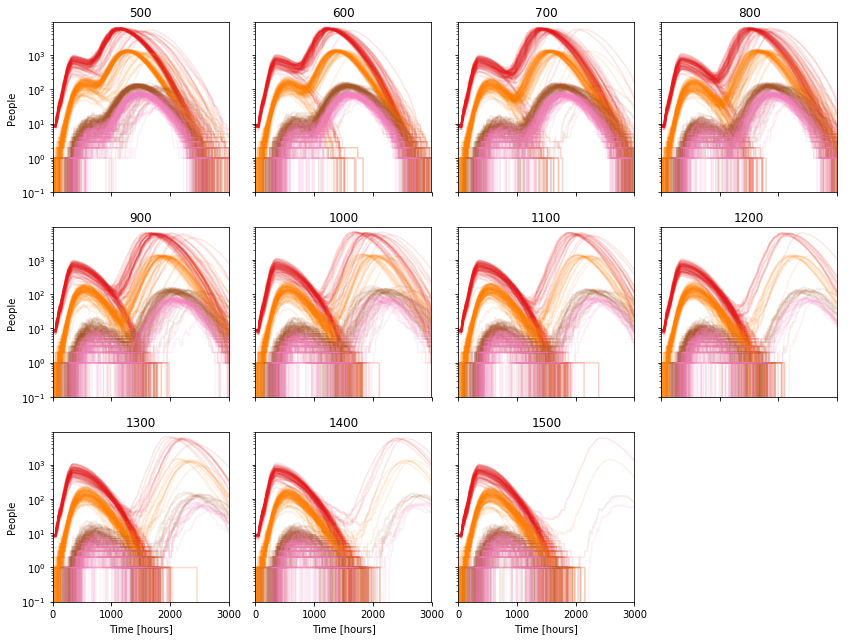

In [36]:
scan = 'reopen_public_scan_500_1500'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']
subplot_order_list = ['_500.000', '_600.000', '_700.000', '_800.000', '_900.000', '_1000.000', \
                      '_1100.000', '_1200.000', '_1300.000', '_1400.000', '_1500.000']

output_folder = data_folder + "/plots/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig9 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,\
                                       scan_order=subplot_order_list, statii=states_list)
ax_series[-1].axis('off')
fig9.savefig(output_folder + "/Reopen_Public_Scan_500_1500_flags.png")

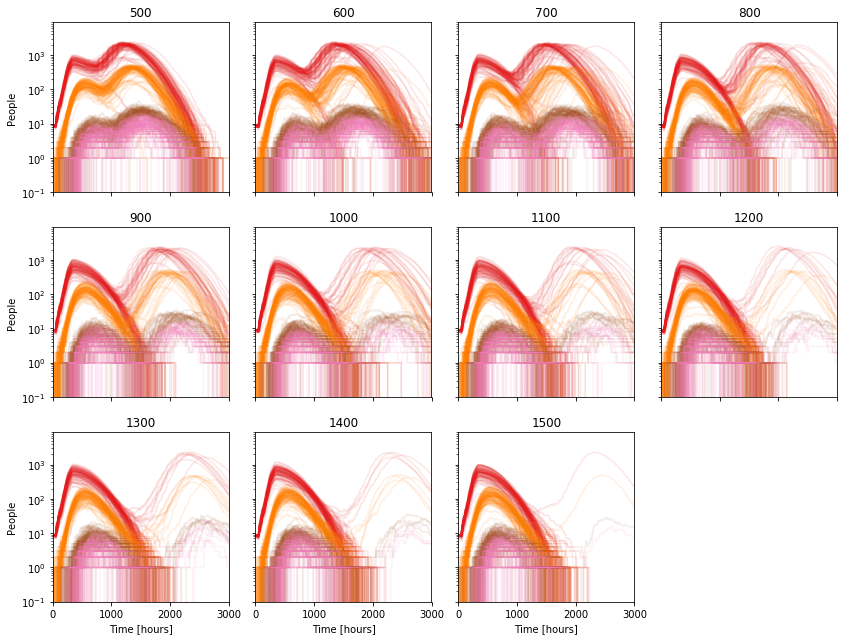

In [37]:
scan = 'reopen_school_scan_500_1500'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']
subplot_order_list = ['_500.000', '_600.000', '_700.000', '_800.000', '_900.000', '_1000.000', \
                      '_1100.000', '_1200.000', '_1300.000', '_1400.000', '_1500.000']

output_folder = data_folder + "/plots/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig9 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,\
                                       scan_order=subplot_order_list, statii=states_list)
ax_series[-1].axis('off')
fig9.savefig(output_folder + "/Reopen_School_Scan_500_1500_flags.png")

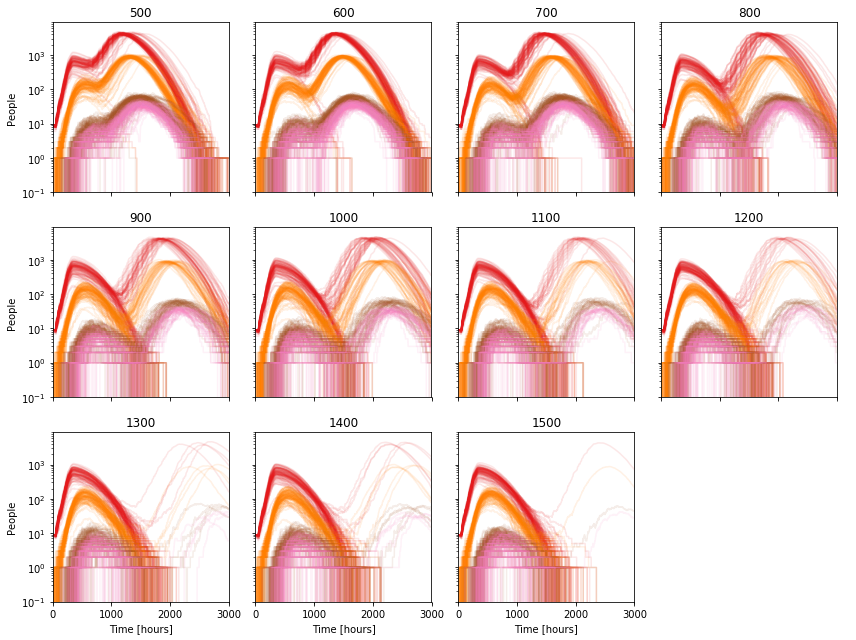

In [38]:
scan = 'reopen_work_scan_500_1500'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']
subplot_order_list = ['_500.000', '_600.000', '_700.000', '_800.000', '_900.000', '_1000.000', \
                      '_1100.000', '_1200.000', '_1300.000', '_1400.000', '_1500.000']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig9 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,\
                                       scan_order=subplot_order_list, statii=states_list)
ax_series[-1].axis('off')
fig9.savefig(output_folder + "/Reopen_Work_Scan_500_1500_flags.png")

<a id='if'></a>
### interaction frequency scans

[back to plot overview](#plots)

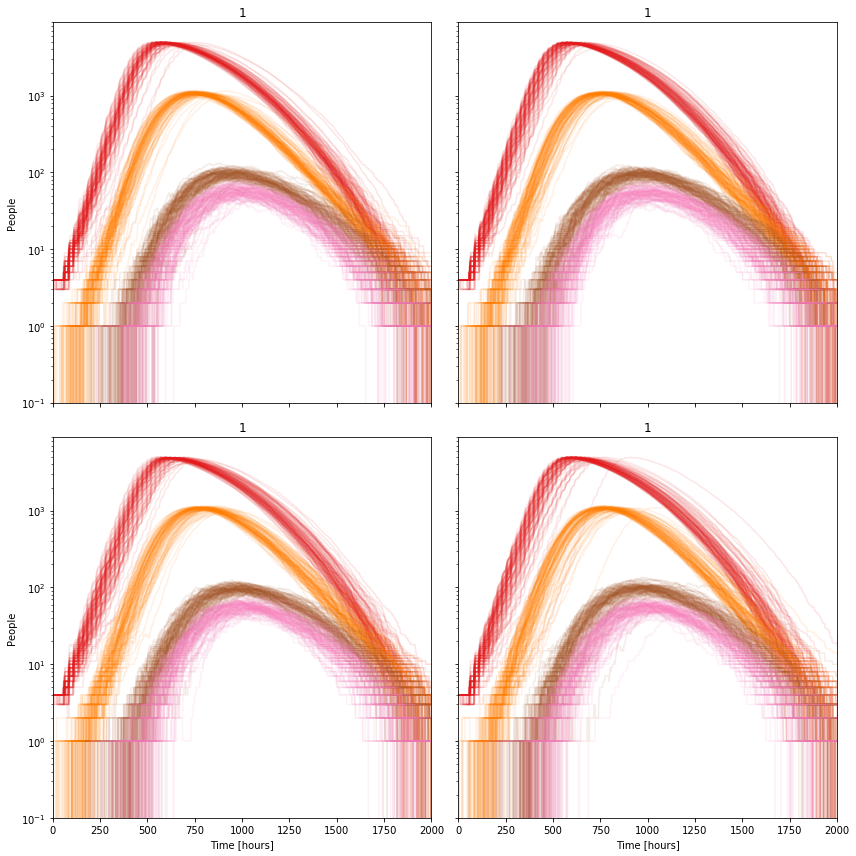

In [39]:
scan = 'modified_interaction_frequencies_Bad_Feilnbach'
data_folder = server_data_folder_str + scan + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x and '.csv' not in x]
states_list=['I', 'Diagnosed', 'Hospitalized', 'ICUed']
#subplot_order_list = ['_500.000', '_600.000', '_700.000', '_800.000', '_900.000', '_1000.000', \
#                      '_1100.000', '_1200.000', '_1300.000', '_1400.000', '_1500.000']

scan_length = len(subfolder_list)
x,y = assign_subplot_grid(scan_length)
ax_series, fig9 = plot_statii_for_scan(server_data_folder_str, scan, subfolder_list, x, y, prefix=0, suffix=10,
                                      statii=states_list)
#ax_series[-1].axis('off')
fig9.savefig(output_folder + "/Interaction_Frequency_Scan_Bad_Feilnbach_flags.png")

#### statii with errors

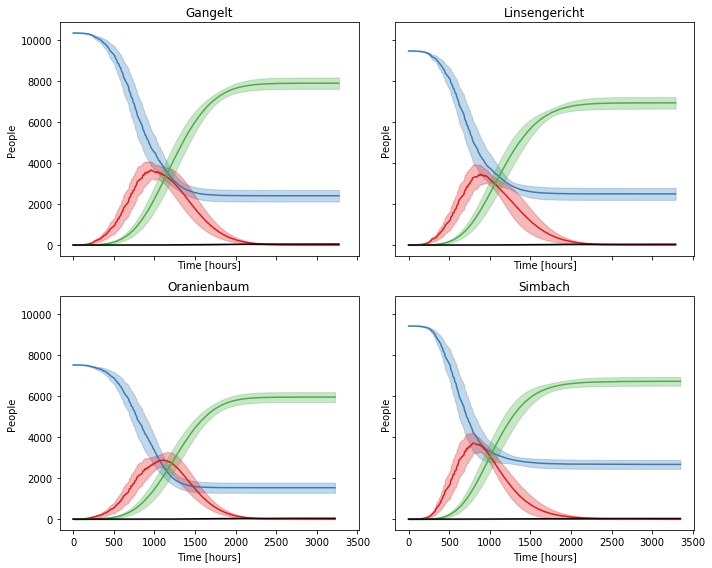

In [5]:
group_folder = 'incidence_scan_LockDownLight'
data_folder = server_data_folder_str+group_folder +'/'
subfolder = os.listdir(data_folder)

fig, axes = plt.subplots(2,2, figsize=(10,8), sharey=True, sharex=True)
ax_series = axes.flatten()

for k,s in enumerate(subfolder):
    #ax_series[k].plot()
    plot_stat_para_mean_error(ax_series[k], s, data_folder)
    ax_series[k].set_title(s.split('_')[0])
plt.tight_layout()    